In [77]:

import pandas as pd 

import numpy as np

import matplotlib as mpl

import matplotlib.pyplot as plt

import sklearn as sl
%matplotlib inline

import scipy as sc

import math as ma

from scipy import linalg, optimize, constants, interpolate, special, stats

from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen

import statsmodels.api as sm

import statsmodels.stats.api as sms

import tensorflow as tf

from tensorflow import keras

import pathlib

import ssl

from sklearn import metrics

import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,root_mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from keras.models import Sequential

# Preprocessing Data

In [78]:
header_pr = ['Year','Month','Day','Hour','pr']
t = ['Year','Month','Day','Hour']
pr_data = pd.read_csv("dataset/pr_hourly_DWD_ID1550.dat",delim_whitespace=True,header=None,names=header_pr,skipinitialspace=True)
q_data = pd.read_csv("dataset/Q_hourly_ID16425004.dat")

C:\Users\davee\AppData\Local\Temp\ipykernel_10140\893981867.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pr_data = pd.read_csv("dataset/pr_hourly_DWD_ID1550.dat",delim_whitespace=True,header=None,names=header_pr,skipinitialspace=True)


In [79]:
data = pd.merge(pr_data, q_data, on=['Year', 'Month', 'Day', 'Hour'], suffixes=('_precip', '_level'))

date_time = pd.to_datetime(data[['Year', 'Month', 'Day', 'Hour']])
data = data.drop(columns=['Year', 'Month', 'Day', "Hour"])

print(data.info())
# No missing values

print(data.describe())
#There are outliers in pr

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213312 entries, 0 to 213311
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pr      213312 non-null  float64
 1   Q       213312 non-null  float64
dtypes: float64(2)
memory usage: 3.3 MB
None
                  pr              Q
count  213312.000000  213312.000000
mean     -398.788224       4.029294
std      6303.568137       3.136641
min    -99999.000000       0.162000
25%         0.000000       1.788000
50%         0.000000       3.167000
75%         0.000000       5.377000
max        37.100000      64.457000


In [80]:
#Replace -99999 with NaN then handle missing values with Interpolation
data.loc[data['pr'] < 0, 'pr'] = np.nan

#time series Interpolation
data['timestamp'] = date_time
data.set_index('timestamp', inplace=True)
data['pr'] = data['pr'].interpolate(method='time')

print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213312 entries, 1995-09-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pr      213312 non-null  float64
 1   Q       213312 non-null  float64
dtypes: float64(2)
memory usage: 4.9 MB
None
                  pr              Q
count  213312.000000  213312.000000
mean        0.154328       4.029294
std         0.660495       3.136641
min         0.000000       0.162000
25%         0.000000       1.788000
50%         0.000000       3.167000
75%         0.000000       5.377000
max        37.100000      64.457000


### Add time-lagged features

In [81]:
#Create lag features for Q
for lag in range(1,7):
    data[f'Q_t-{lag}'] = data['Q'].shift(lag)
    
#Target Variable
data['Q_t+6'] = data['Q'].shift(-6)

#Drop rows with NaN values caused by lagging
data.dropna(inplace=True)

print(data)

                      pr       Q   Q_t-1   Q_t-2   Q_t-3   Q_t-4   Q_t-5  \
timestamp                                                                  
1995-09-01 06:00:00  0.1  11.026  11.170  11.313  11.457  11.601  11.745   
1995-09-01 07:00:00  0.2  10.882  11.026  11.170  11.313  11.457  11.601   
1995-09-01 08:00:00  0.2   8.551  10.882  11.026  11.170  11.313  11.457   
1995-09-01 09:00:00  0.3  10.758   8.551  10.882  11.026  11.170  11.313   
1995-09-01 10:00:00  0.8  10.109  10.758   8.551  10.882  11.026  11.170   
...                  ...     ...     ...     ...     ...     ...     ...   
2019-12-31 13:00:00  0.0   1.964   1.964   1.964   1.964   1.964   1.964   
2019-12-31 14:00:00  0.0   1.964   1.964   1.964   1.964   1.964   1.964   
2019-12-31 15:00:00  0.0   1.965   1.964   1.964   1.964   1.964   1.964   
2019-12-31 16:00:00  0.0   1.965   1.965   1.964   1.964   1.964   1.964   
2019-12-31 17:00:00  0.0   1.965   1.965   1.965   1.964   1.964   1.964   

           

### Finding out the correlation between features for time-lagged series 

In [82]:
# Calculate correlation matrix
correlation_matrix = data.corr()

# Extract correlation of each feature with the target
correlation_with_target = correlation_matrix["Q_t+6"].sort_values(ascending=False)

# Print correlation values
print("Correlation of features with target:")
print(correlation_with_target)

Correlation of features with target:
Q_t+6    1.000000
Q        0.963880
Q_t-1    0.956978
Q_t-2    0.950113
Q_t-3    0.943431
Q_t-4    0.936901
Q_t-5    0.930562
Q_t-6    0.924451
pr       0.232956
Name: Q_t+6, dtype: float64


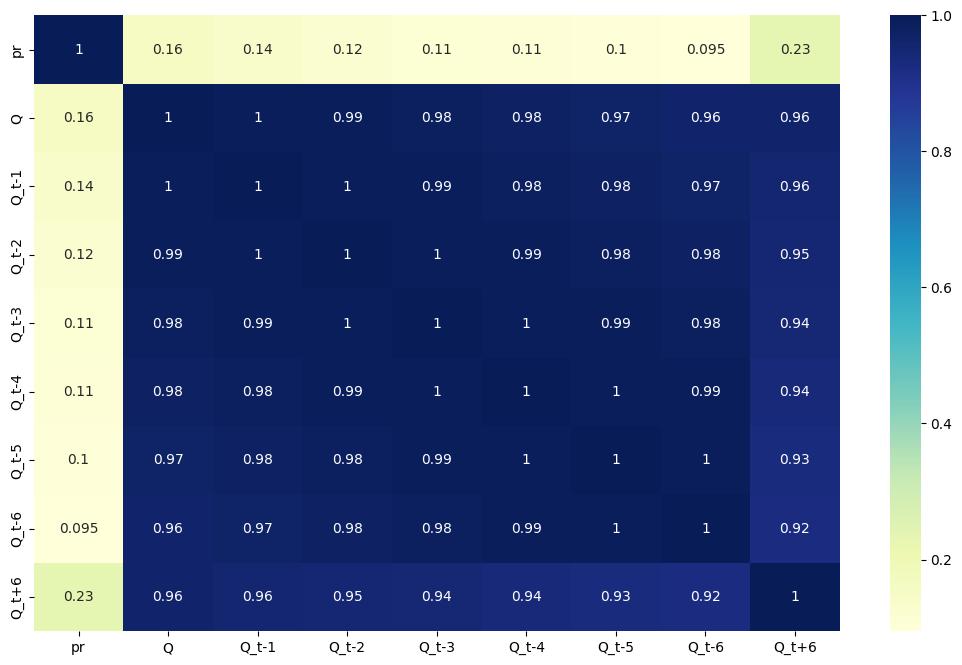

In [83]:
#Correlation Heat Map
fig = plt.figure(figsize=(13,8))
sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)

plt.show()

In [84]:
#Split into X (inputs) and y (target)
X = data[["Q","Q_t-1", "Q_t-2", "Q_t-3", "Q_t-4", "pr"]]
y = data["Q_t+6"]

# Train-test split (random seed = 42 to ensure same results very run)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = False)

#Standardise the features to get numerical stability 
scaler = StandardScaler()
features = ["Q","Q_t-1", "Q_t-2", "Q_t-3", "Q_t-4", "pr"]
data[features] = scaler.fit_transform(data[features])


### Key Observations 
- High Correlations Among Lagged Levels:
The features Level(t-1) through Level(t-6) are highly correlated with each other (correlation ~0.98-0.99). This can also suggests that the relationship is linear. 

- Correlation with the Target:
Precipitation (pr) and lagged levels (Level(t-1) to Level(t-6)) are moderately correlated with the target variable. This suggests these are meaningful predictors.
Other features like Year, Month, Day, and Hour have weak correlations with the target, so they might not add much predictive power.

# Linear Modell 

### Single Train-Test Split 

In [9]:
LinearModel = LinearRegression()
LinearModel.fit(X_train, y_train)

y_pred = LinearModel.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Linear Model Performance")

print(f'MAE: {mae}')

#RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

#R2
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

print('\n')
# Display predictions vs actual values
predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(predictions.head())


Linear Model Performance
MAE: 0.2915570547281538
RMSE: 0.8328277804096756
R² Score: 0.9306793101151679


                     Actual  Predicted
timestamp                             
2012-09-12 12:00:00   7.182   6.316252
2012-09-12 13:00:00   6.906   6.294053
2012-09-12 14:00:00   6.839   7.420933
2012-09-12 15:00:00   6.907   7.472060
2012-09-12 16:00:00   6.705   6.994150


In [10]:
y_test

timestamp
2012-09-12 12:00:00    7.182
2012-09-12 13:00:00    6.906
2012-09-12 14:00:00    6.839
2012-09-12 15:00:00    6.907
2012-09-12 16:00:00    6.705
                       ...  
2019-12-31 13:00:00    1.965
2019-12-31 14:00:00    1.965
2019-12-31 15:00:00    1.965
2019-12-31 16:00:00    1.965
2019-12-31 17:00:00    1.965
Name: Q_t+6, Length: 63990, dtype: float64

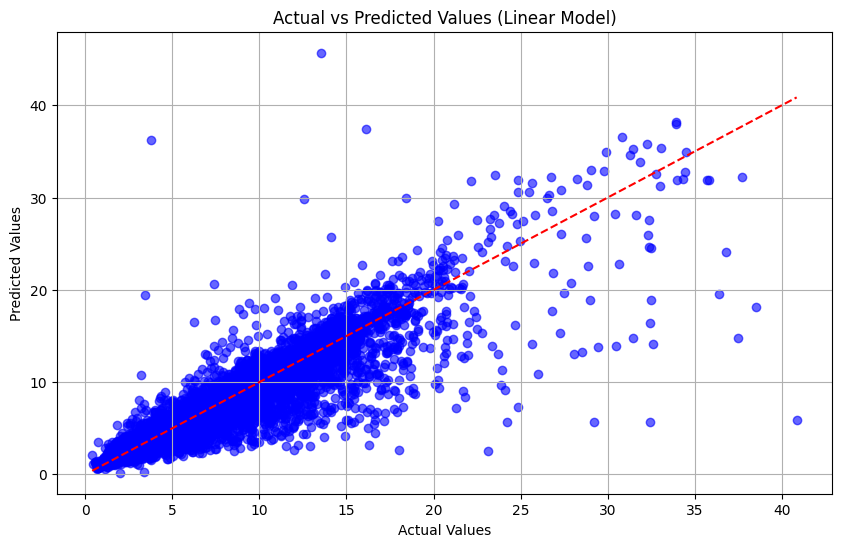

In [11]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (Linear Model)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

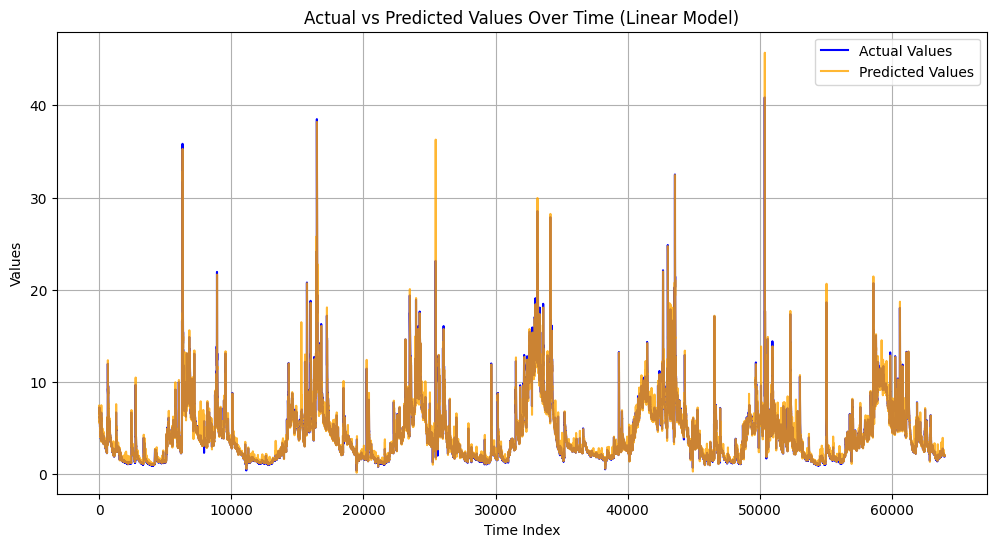

In [12]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time (Linear Model)')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

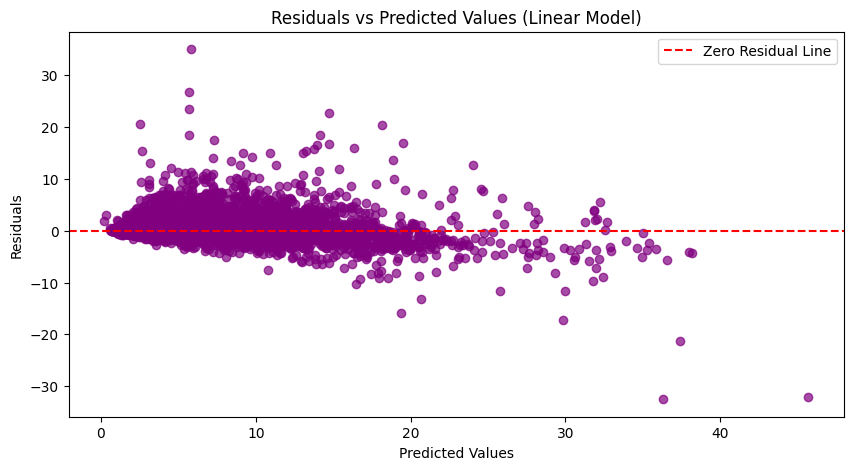

In [13]:
residuals = y_test - y_pred

# Residuals vs. Predicted Values
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Linear Model)')
plt.legend()
plt.show()


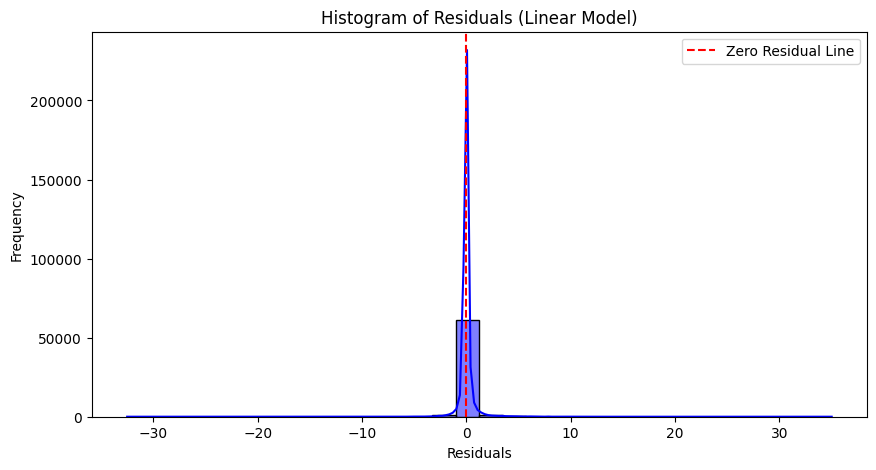

In [14]:
# Histogram of residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Linear Model)')
plt.legend()
plt.show()

### K-Fold Cross Validation 

In [15]:
# Define k-fold cross-validation
kfModel = KFold(n_splits=5, shuffle=False)

# List to store the scores
rmse_scores = []
mae_scores = []
r2_scores = []
all_residuals = []
all_y_pred = []
all_y_test = []

# Perform k-fold cross-validation
for train_index, test_index in kfModel.split(X):
    X_train_KF, X_test_KF = X.iloc[train_index], X.iloc[test_index]
    y_train_KF, y_test_KF = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression()
    model.fit(X_train_KF, y_train_KF)
    y_pred = model.predict(X_test_KF)
    
    # Evaluate
    mse = mean_squared_error(y_test_KF, y_pred)
    rmse = np.sqrt(mse)  
    mae = mean_absolute_error(y_test_KF, y_pred)
    r2 = r2_score(y_test_KF, y_pred)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    # Collect residuals
    residuals = y_test_KF - y_pred
    all_residuals.extend(residuals)
    all_y_pred.extend(y_pred)
    all_y_test.extend(y_test_KF)

# Convert to arrays for plotting
all_residuals = np.array(all_residuals)
all_y_pred = np.array(all_y_pred)
all_y_test = np.array(all_y_test)

print("K-Fold Validation Performance")
print(f"Average RMSE: {rmse}")
print(f"Average R² Score: {r2}")
print(f'Average MAE: {np.mean(mae_scores)}')


K-Fold Validation Performance
Average RMSE: 0.8551860006990135
Average R² Score: 0.9284648750216183
Average MAE: 0.27741247255118473


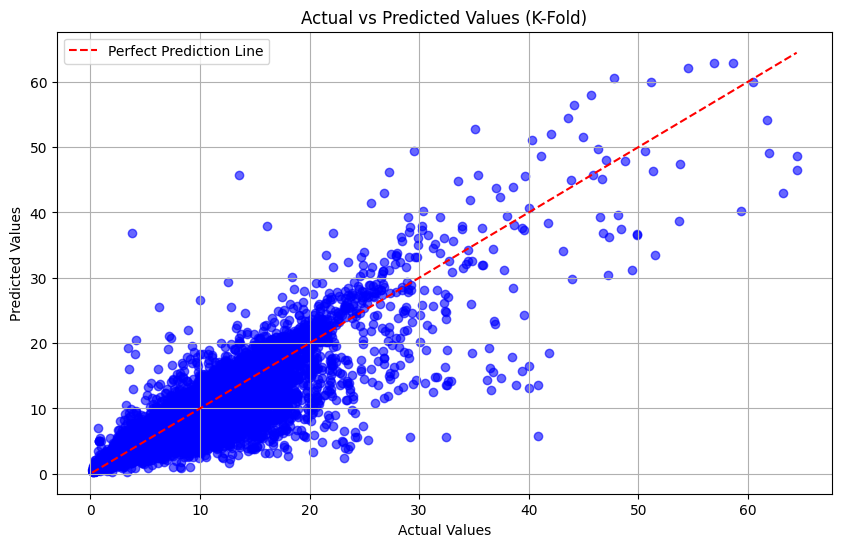

In [16]:
#Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(all_y_test, all_y_pred, alpha=0.6, color='blue')
plt.plot([all_y_test.min(), all_y_test.max()], [all_y_test.min(), all_y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.title('Actual vs Predicted Values (K-Fold)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()


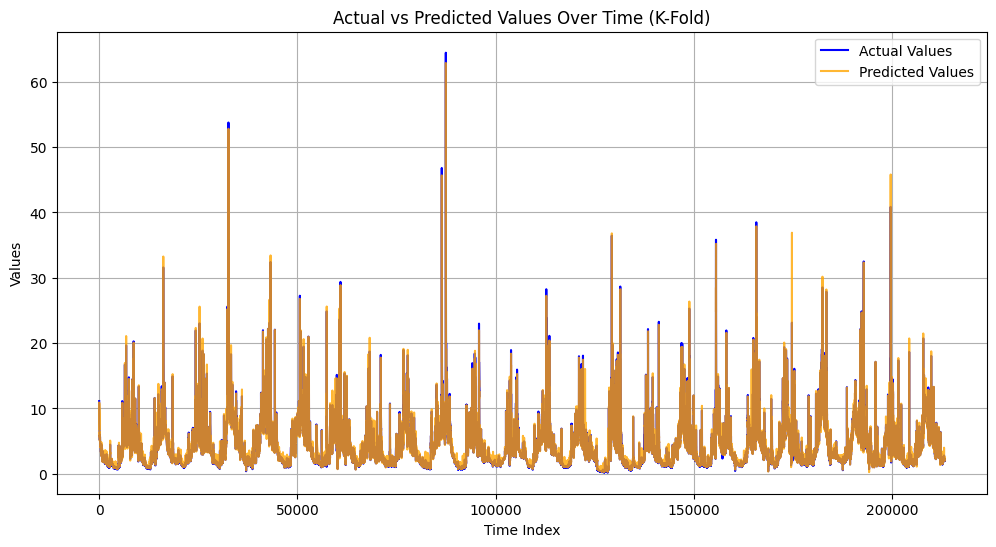

In [17]:
#Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(all_y_test)), all_y_test, label='Actual Values', color='blue')
plt.plot(range(len(all_y_pred)), all_y_pred, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time (K-Fold)')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

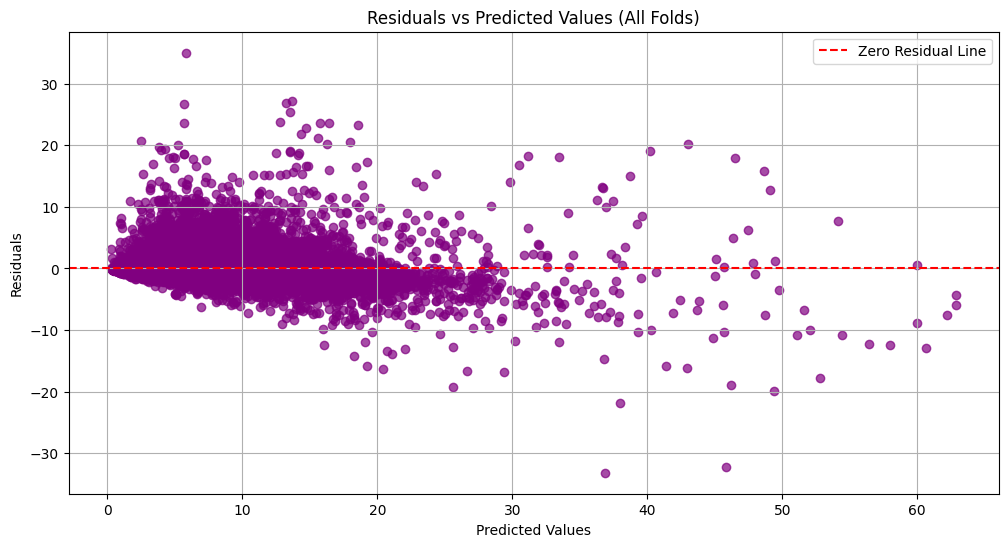

In [18]:
# Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
plt.scatter(all_y_pred, all_residuals, alpha=0.7, color='purple')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (All Folds)')
plt.legend()
plt.grid(True)
plt.show()

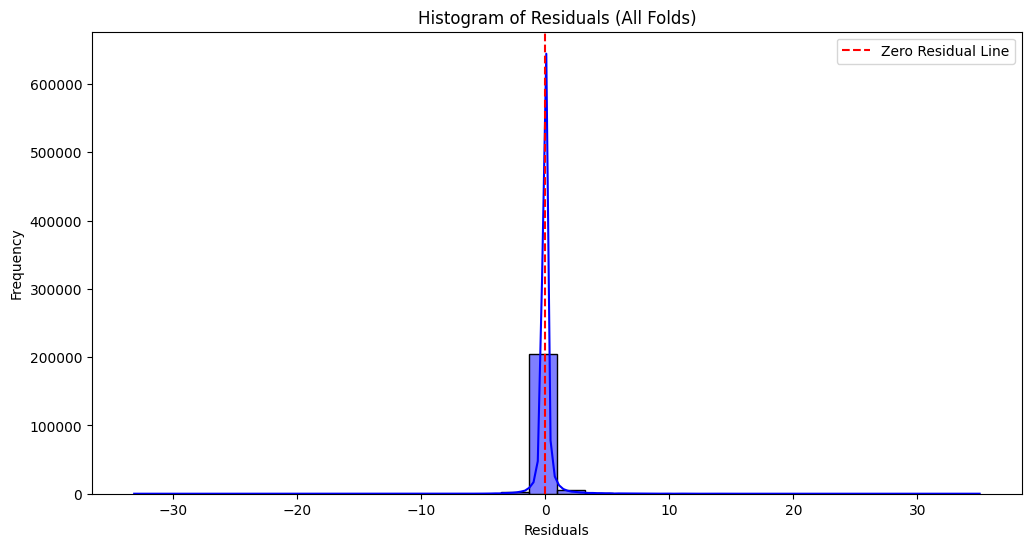

In [19]:
# Histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(all_residuals, kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (All Folds)')
plt.legend()
plt.show()

Observations from the Histogram:
1. Centered Around Zero: The residuals are predominantly centered around zero, which suggests that the model is not systematically overpredicting or underpredicting the target values. This is an essential indicator of a well-performing model since the residuals are centered around zero, it indicates that the model is unbiased.
2. Symmetrical Shape: The distribution appears to be roughly symmetrical, which is ideal. This implies that the errors are evenly distributed on both sides of the predicted values, another sign that the model is well-calibrated.
3. Small Spread: The majority of residuals are clustered tightly around zero, which indicates that the model's predictions are quite accurate. A narrow spread of residuals generally suggests low variance in prediction errors.


### Feature Importance
- Check linear regression coefficients.


In [20]:
coefficients = model.coef_

# Create a DataFrame to view the feature names with their corresponding coefficients
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()

# Sort by the absolute value of the coefficients
feature_importance_sorted = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
print(feature_importance_sorted)


  Feature  Coefficient  Absolute_Coefficient
0       Q     1.161108              1.161108
5      pr     0.364113              0.364113
1   Q_t-1    -0.108850              0.108850
3   Q_t-3    -0.078436              0.078436
2   Q_t-2    -0.075003              0.075003
4   Q_t-4     0.051452              0.051452


### Address Multicollinearity:
- Compare performance of Ridge and Lasso with the plain linear regression model.

In [21]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
ridge = Ridge(alpha=100.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# Evaluate the model
print("Ridge Regression Performance")

rmse_ridge = ma.sqrt(mean_squared_error(y_test, ridge_pred))
print(f"Root Mean Squared Error: {rmse:f}")

mae_r = mean_absolute_error(y_test, ridge_pred)
print(f"Mean Absolute Error: {mae:f}")

r2 = r2_score(y_test, ridge_pred)
print(f"R2 Score: {r2:f}")

Ridge Regression Performance
Root Mean Squared Error: 0.855186
Mean Absolute Error: 0.304913
R2 Score: 0.930703


In [22]:
y_test

timestamp
2012-09-12 12:00:00    7.182
2012-09-12 13:00:00    6.906
2012-09-12 14:00:00    6.839
2012-09-12 15:00:00    6.907
2012-09-12 16:00:00    6.705
                       ...  
2019-12-31 13:00:00    1.965
2019-12-31 14:00:00    1.965
2019-12-31 15:00:00    1.965
2019-12-31 16:00:00    1.965
2019-12-31 17:00:00    1.965
Name: Q_t+6, Length: 63990, dtype: float64

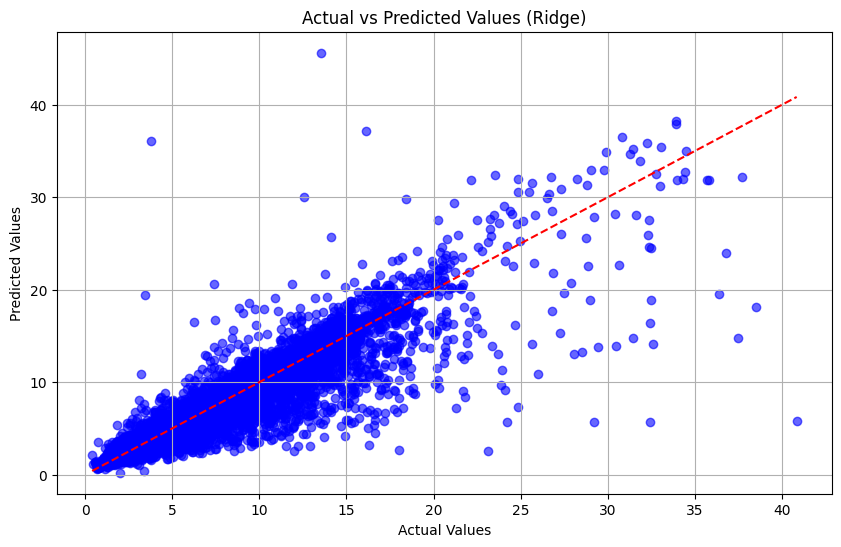

In [23]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (Ridge)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

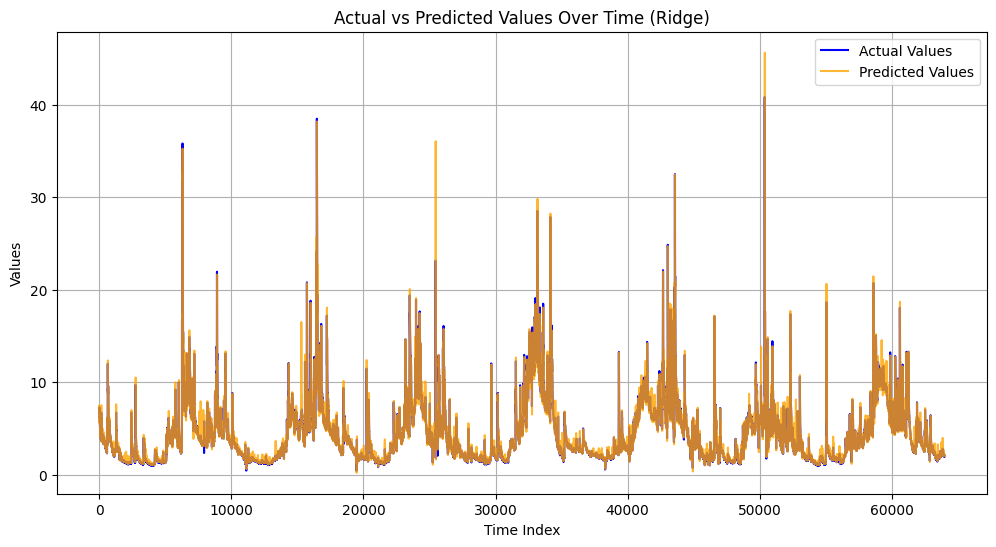

In [24]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(ridge_pred)), ridge_pred, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time (Ridge)')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

In [25]:
# Ridge Regression with Cross-Validation
ridge_cv = GridSearchCV(Ridge(), param_grid={'alpha': [0.1, 1.0, 10.0, 100.0]}, cv=5)
ridge_cv.fit(X_train, y_train)
print(f'Best Ridge alpha: {ridge_cv.best_params_}')

Best Ridge alpha: {'alpha': 100.0}


In [26]:
# Ridge Coefficients
ridge_coefficients = pd.Series(ridge.coef_, index=X_train.columns).sort_values(key=abs, ascending=False)
print("Ridge Coefficients:")
print(ridge_coefficients)

Ridge Coefficients:
Q        1.130218
pr       0.356994
Q_t-1   -0.072883
Q_t-3   -0.072315
Q_t-2   -0.068736
Q_t-4    0.034452
dtype: float64


# Regression Tree

### Decision Tree

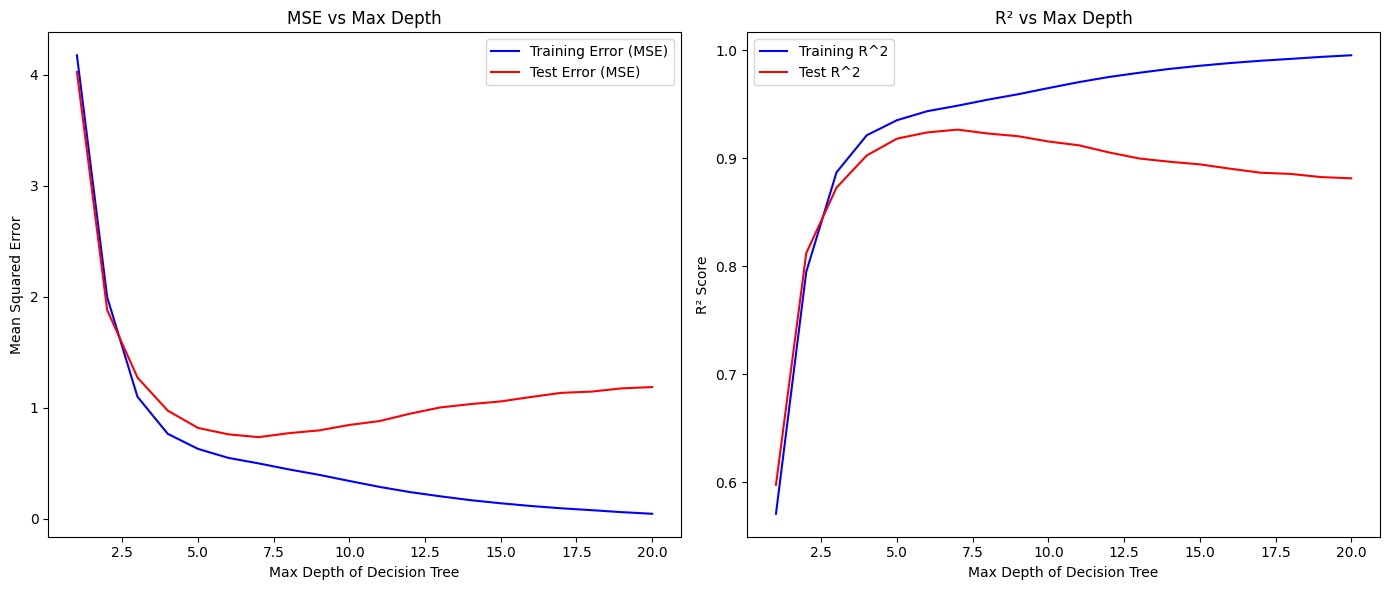

In [27]:
train_errors = []
test_errors = []
train_r2 = []
test_r2 = []

# Loop over different depths of the decision tree
max_depth_values = range(1, 21) 

for depth in max_depth_values:
    # Create a decision tree regressor with the given max depth
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(X_train, y_train)
    
    # Predict on the training and test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate Mean Squared Error
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Calculate R^2 Score
    train_r2_score = r2_score(y_train, y_train_pred)
    test_r2_score = r2_score(y_test, y_test_pred)
    
    # Append to the lists
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    train_r2.append(train_r2_score)
    test_r2.append(test_r2_score)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot MSE for training and test set
ax[0].plot(max_depth_values, train_errors, label='Training Error (MSE)', color='blue')
ax[0].plot(max_depth_values, test_errors, label='Test Error (MSE)', color='red')
ax[0].set_title('MSE vs Max Depth')
ax[0].set_xlabel('Max Depth of Decision Tree')
ax[0].set_ylabel('Mean Squared Error')
ax[0].legend()

# Plot R^2 Score for training and test set
ax[1].plot(max_depth_values, train_r2, label='Training R^2', color='blue')
ax[1].plot(max_depth_values, test_r2, label='Test R^2', color='red')
ax[1].set_title('R² vs Max Depth')
ax[1].set_xlabel('Max Depth of Decision Tree')
ax[1].set_ylabel('R² Score')
ax[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [93]:
tree = DecisionTreeRegressor(max_depth=7)  
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)

print(f'Decision Tree RMSE: {root_mean_squared_error(y_test, tree_predictions)}')
print(f'Decision Tree MAE: {mean_absolute_error(y_test, tree_predictions)}')

r_squared = r2_score(y_test, tree_predictions)
print('Decision Tree R2:',r_squared)

Decision Tree RMSE: 0.8586964398728878
Decision Tree MAE: 0.3021902212788003
Decision Tree R2: 0.9263060570031185


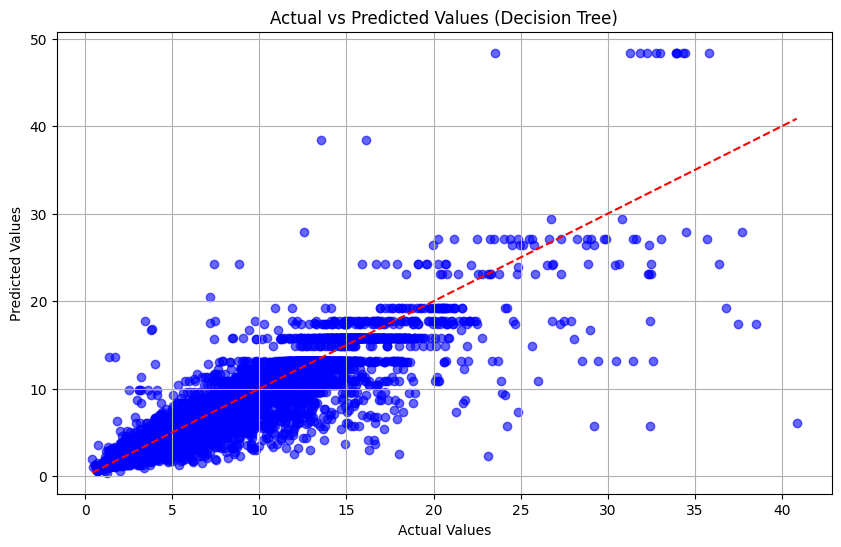

In [94]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, tree_predictions,alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (Decision Tree)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

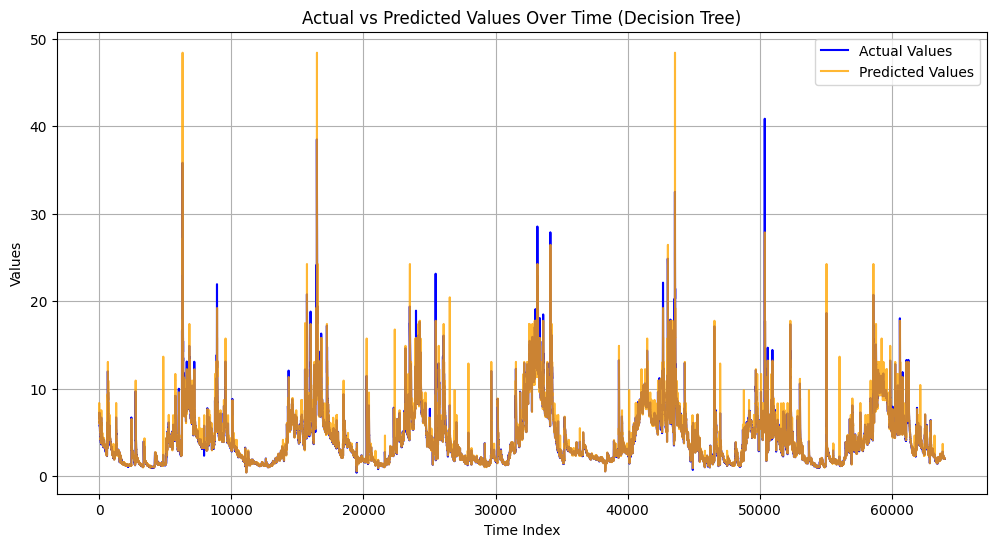

In [30]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(tree_predictions)), tree_predictions, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time (Decision Tree)')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

### Bagging 

### Finding optimal number of n-estimator

In [31]:
baggingReg = BaggingRegressor(DecisionTreeRegressor(),
                         n_estimators=100, bootstrap=True).fit(X_train, y_train)

y_hat_test_Bag = baggingReg.predict(X_test)

In [32]:
#RMSE
rmseTree_Bag_test = sqrt(mean_squared_error(y_hat_test_Bag,y_test)) 

print('RMSE Testfehler:',rmseTree_Bag_test)

#R2
r2 = r2_score(y_test, y_hat_test_Bag)
print(f"R² Score: {r2}")

mae = mean_absolute_error(y_test, y_hat_test_Bag)
print(f'MAE: {mae}')


RMSE Testfehler: 0.8191546755849152
R² Score: 0.9329367960002168
MAE: 0.3034525883335226


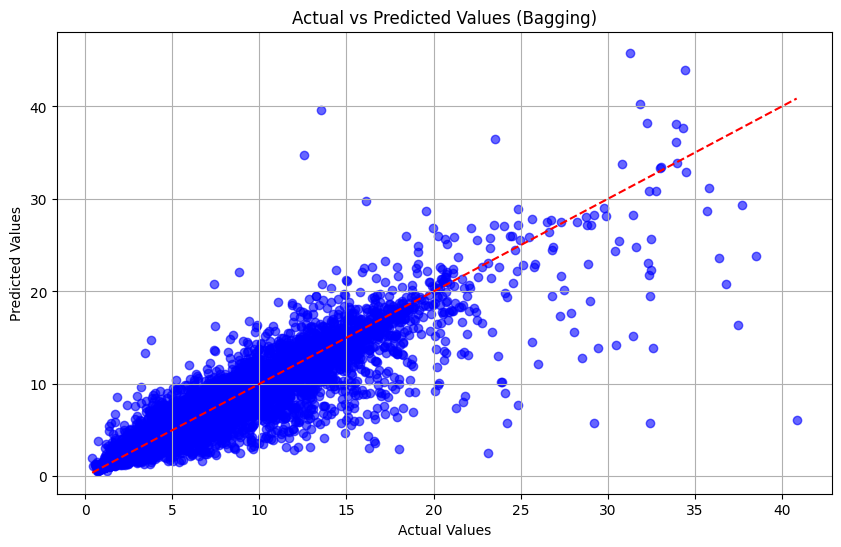

In [33]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_hat_test_Bag, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (Bagging)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

randomforest = RandomForestRegressor(n_estimators=100, max_depth=10) 
randomforest.fit(X_train, y_train)
rf_predictions = randomforest.predict(X_test)

# Mean Absolute Error (MAE)
mae = metrics.mean_absolute_error(y_test, rf_predictions)
print("Mean Absolute Error (MAE):", mae)

# Mean Squared Error (MSE)
mse = metrics.mean_squared_error(y_test, rf_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# R² Score
r2 = metrics.r2_score(y_test, rf_predictions)
print("R² Score:", r2)


Mean Absolute Error (MAE): 0.2798060181706068
Root Mean Squared Error (RMSE): 0.8037012491828508
R² Score: 0.935443235481682


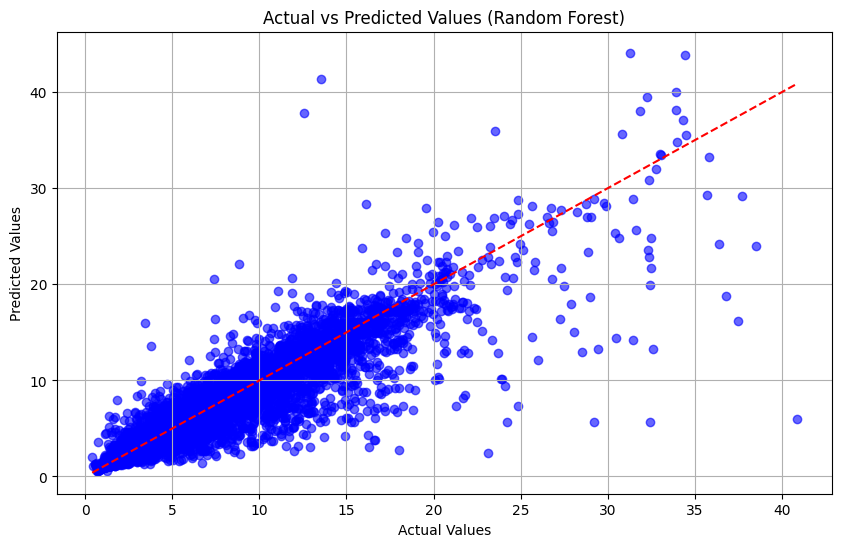

In [62]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (Random Forest)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

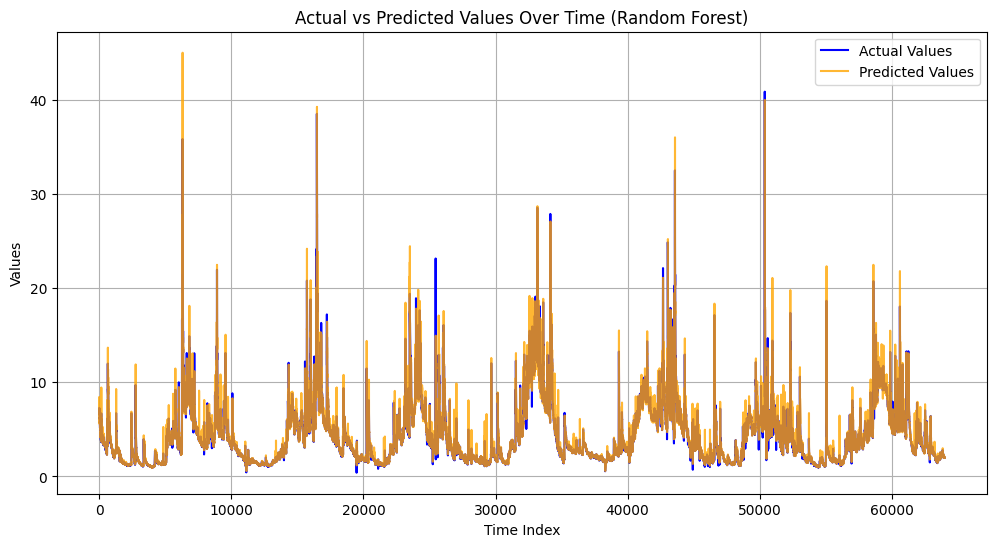

In [35]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(rf_predictions)), rf_predictions, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time (Random Forest)')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

### Gradient Boosting 

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
gb.fit(X_train, y_train)
gb_predictions = gb.predict(X_test)

print(f'Gradient Boosting RMSE: {root_mean_squared_error(y_test, gb_predictions)}')
print(f'Gradient Boosting MAE: {mean_absolute_error(y_test, gb_predictions)}')

# R² Score
r2 = metrics.r2_score(y_test, gb_predictions)
print("R² Score:", r2)


Gradient Boosting RMSE: 0.7838713659033739
Gradient Boosting MAE: 0.27642519712883573
R² Score: 0.9385895796450061


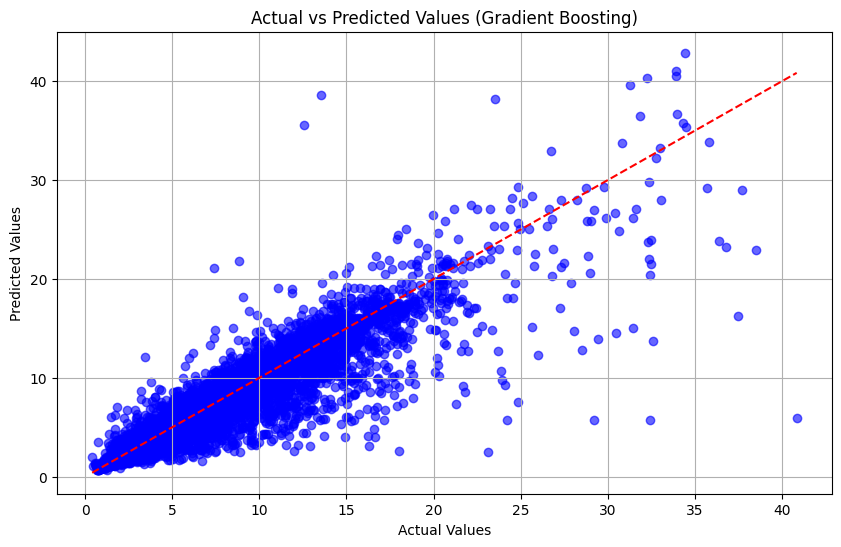

In [37]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gb_predictions, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (Gradient Boosting)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

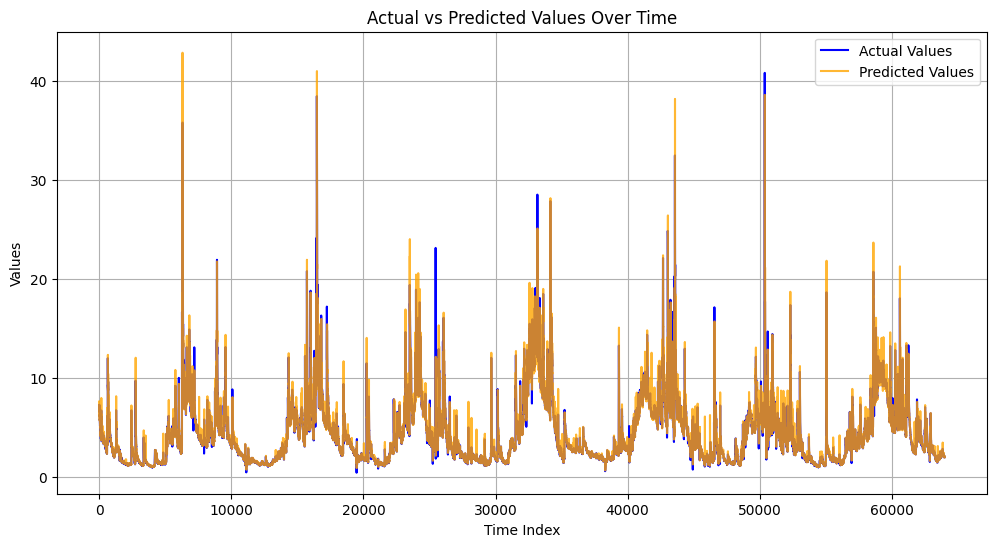

In [38]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(gb_predictions)), gb_predictions, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

### Neural Network

In [39]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [63]:
X = np.array(data[['pr','Q','Q_t-1','Q_t-2','Q_t-3','Q_t-4']])
y = np.array(data['Q_t+6'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Dense
### EarlyStopping, Adam Optimizer, Epoch=50, batch_size=16

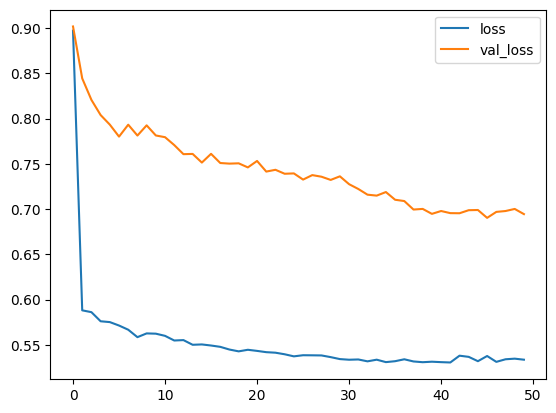

9332/9332 ━━━━━━━━━━━━━━━━━━━━ 7s 712us/step - loss: 0.4435 - mae: 0.2429 - val_loss: 0.6944 - val_mae: 0.3898


In [67]:


EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)

denseNN=Sequential()

#Layers
denseNN.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))  # Features = 8

# Output Layer
denseNN.add(Dense(1, activation='linear'))  # Regression output

#Optimizer
adam = Adam(learning_rate=0.001)
#sgd = SGD(learning_rate=0.005)

denseNN.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])

denseNN.fit(X_train, y_train,
          shuffle=False,
          epochs=50, #300,
          batch_size=16,
          verbose=1,
          validation_data=(X_test, y_test),                  
          callbacks=[plot_losses, EarlyStopping])

In [68]:
from sklearn.metrics import r2_score
# Evaluate the model on the test set
test_loss, test_mae = denseNN.evaluate(X_test, y_test, verbose=0)

# Print evaluation results
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")

#predict on test set
y_pred = denseNN.predict(X_test)

# Calculate RMSE and R² score
rmse = np.sqrt(test_loss)  # Since test_loss = MSE
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Test Loss (MSE): 0.6902682781219482
Mean Absolute Error (MAE): 0.3845013976097107
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step
Root Mean Squared Error (RMSE): 0.8308238550510861
R² Score: 0.9310124972318939


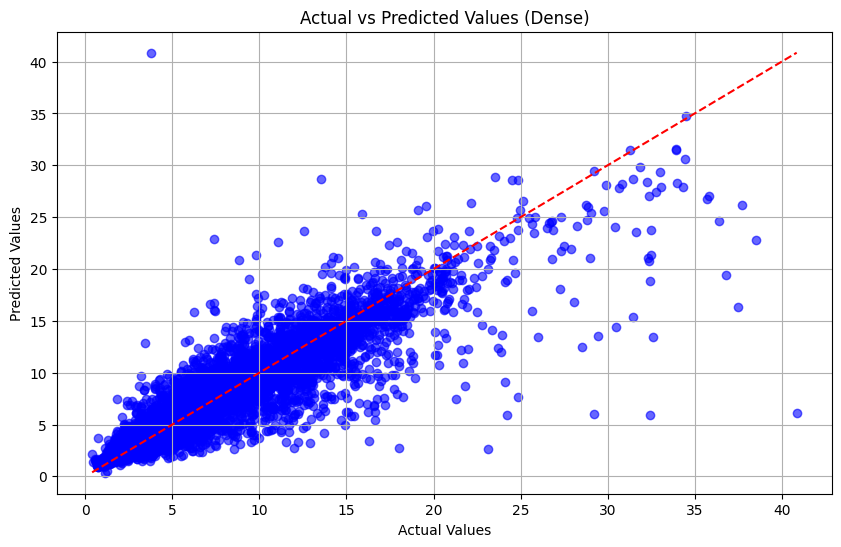

In [69]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (Dense)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

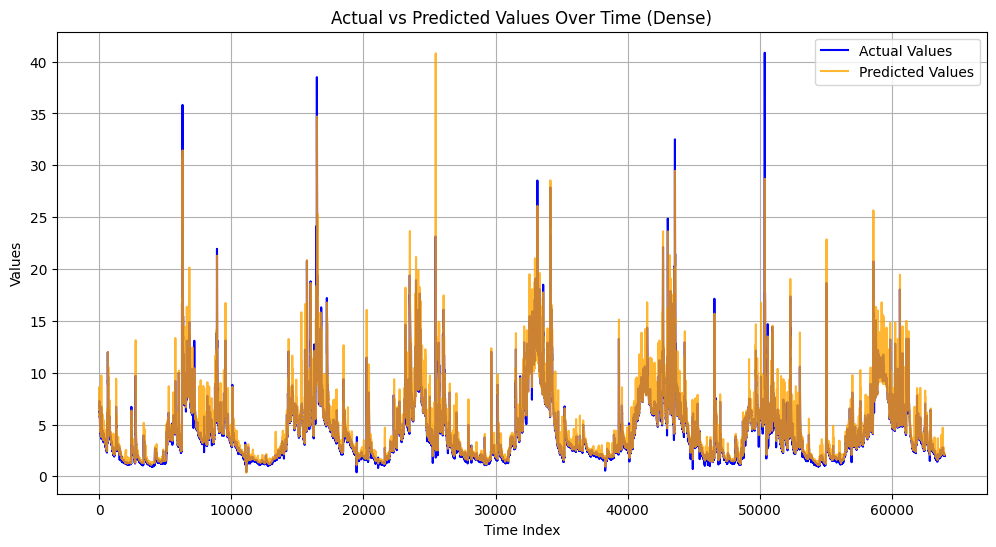

In [70]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time (Dense)')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

## LSTM

In [71]:
X = data[['pr','Q','Q_t-1','Q_t-2','Q_t-3','Q_t-4','Q_t-5','Q_t-6']].values
y = data['Q_t+6'].values


scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape input for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

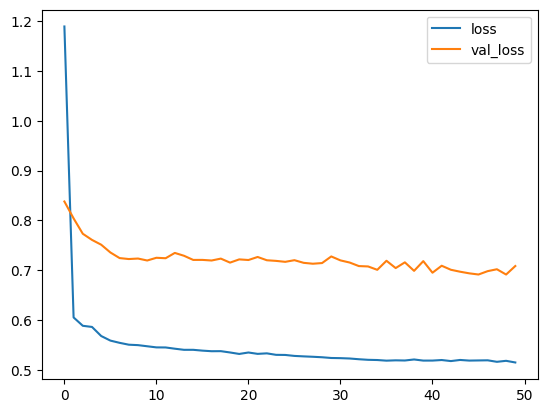

9332/9332 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 0.4325 - mae: 0.2354 - val_loss: 0.7086 - val_mae: 0.3633


In [72]:
from keras.models import Sequential
from keras.layers import LSTM, Dense


EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights=True)
# Build the model
lstmNN = Sequential()
lstmNN.add(LSTM(64, activation='relu', input_shape=(6, X.shape[2])))  # 6 timesteps, 7 features
lstmNN.add(Dense(1))  # Single output for regression

# Compile the model
lstmNN.compile(optimizer='adam', loss='mse')

#Optimizer
adam = Adam(learning_rate=0.001)
#sgd = SGD(learning_rate=0.005)

lstmNN.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])

lstmNN.fit(X_train, y_train,
          shuffle=False,
          epochs=50, #300,
          batch_size=16,
          verbose=1,
          validation_data=(X_test, y_test),                  
          callbacks=[plot_losses, EarlyStopping])

In [73]:
# Evaluate the model on the test set
test_loss, test_mae = lstmNN.evaluate(X_test, y_test, verbose=0)

# Print evaluation results
print(f"Test Loss (MSE): {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")

#predict on test set
y_pred = lstmNN.predict(X_test)

# Calculate RMSE and R² score
rmse = np.sqrt(test_loss)  # Since test_loss = MSE
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Test Loss (MSE): 0.6915228962898254
Mean Absolute Error (MAE): 0.34874823689460754
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step
Root Mean Squared Error (RMSE): 0.8315785568963556
R² Score: 0.9308871518400379


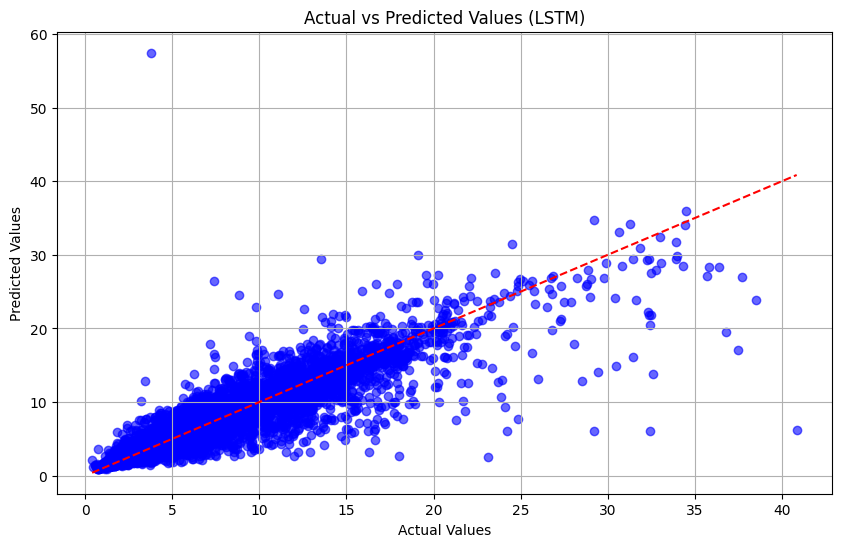

In [74]:
# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.title('Actual vs Predicted Values (LSTM)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

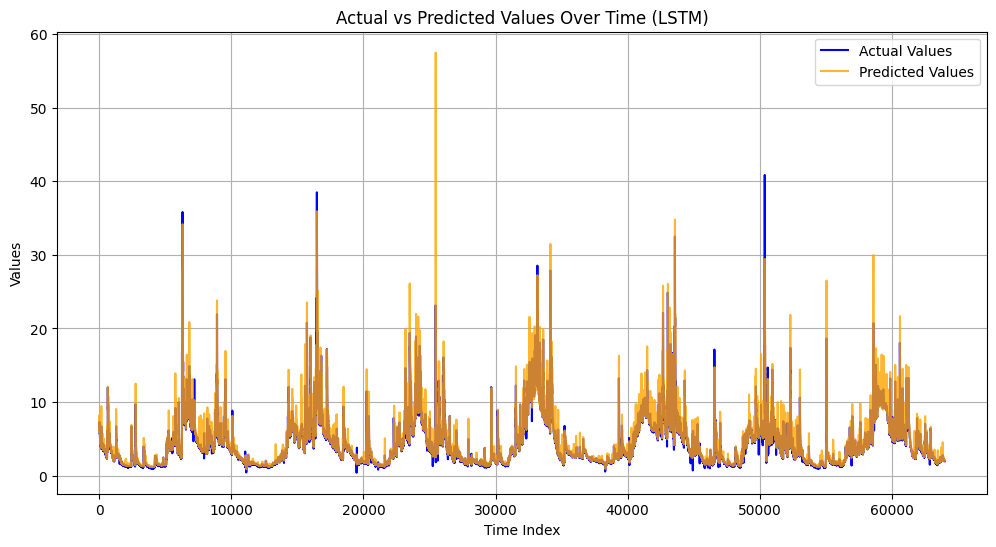

In [75]:
# Plot Predicted vs Actual values over a time index
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Values', color='orange', alpha=0.8)
plt.title('Actual vs Predicted Values Over Time (LSTM)')
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()